<a href="https://colab.research.google.com/github/9mao9/WideResNet/blob/main/WideResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

#**WideResNet network model**

$$
\rm{Network\ depth} = 6n + 4
$$

$\rm{n}$ is a number of blocks, and 4 is the number of layers except the residual block.

In [ ]:
class WideResNet(nn.Module):
  def __init__(self, output_dim, depth, wide_coef=1):
    super(WideResNet, self).__init__()
    n = (depth - 4) // 6

    # conv1
    self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=1, padding=1, bias=False)

    # con2
    self.id1 = Block(channel_in=16, channel_out=16 * wide_coef, stride=1, identity=True)
    self.block1 = nn.ModuleList([Block(channel_in=16 * wide_coef, channel_out=16 * wide_coef, stride=1, identity=False) for _ in range(n-1)])

    # conv3
    self.id2 = Block(channel_in=16 * wide_coef, channel_out=32 * wide_coef, stride=2, identity=True)
    self.block2 = nn.ModuleList([Block(channel_in=32 * wide_coef, channel_out=32 * wide_coef, stride=1, identity=False) for _ in range(n-1)])

    # conv4
    self.id3 = Block(channel_in=32 * wide_coef, channel_out=64 * wide_coef, stride=2, identity=True)
    self.block3 = nn.ModuleList([Block(channel_in=64 * wide_coef, channel_out=64 * wide_coef, stride=1, identity=False) for _ in range(n-1)])

    # Avg_pool
    self.avg_pool = GlobalAvgPool2d()
    self.fc = nn.Linear(64 * wide_coef, 8, bias=False)
    self.out = nn.Linear(8, output_dim, bias=False)

  def forward(self, x):
    h = self.conv1(x)
    h = self.id1(h)
    for block in self.block1:
      h = block(h)
    h = self.id2(h)
    for block in self.block2:
      h = block(h)
    h = self.id3(h)
    for block in self.block3:
      h = block(h)
    h = torch.relu(h)
    h = self.avg_pool(h)
    h = self.fc(h)
    h = self.out(h)
    y = torch.log_softmax(h, dim=-1)
    return y

In [ ]:
class Block(nn.Module):
  def __init__(self, channel_in, channel_out, stride, identity):
    super(Block, self).__init__()
    channel = int(channel_out / 2)

    # 3x3 conv
    self.bn1 = nn.BatchNorm2d(channel_in)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(channel_in, channel, kernel_size=(3, 3), stride=stride, padding=1, bias=False)
    
    # 3x3 conv
    self.bn2 = nn.BatchNorm2d(channel)
    self.relu2 = nn.ReLU(inplace=True)
    self.drop_out = nn.Dropout(p=0.3)
    self.conv2 = nn.Conv2d(channel, channel_out, kernel_size=(3, 3), padding=1, bias=False)
    
    # skip connection
    self.identity = identity
    self.downsample = DownSample(channel_in, channel_out, stride)
    self.init_weights()

  def init_weights(self):
    for _, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(module, nn.BatchNorm2d):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

  def forward(self, x):
    h = self.bn1(x)
    h = self.relu1(h)
    h = self.conv1(h)
    h = self.bn2(h)
    h = self.relu2(h)
    h = self.drop_out(h)
    h = self.conv2(h)
    shortcut = self.downsample(x) if self.identity else x
    y = h + shortcut
    return y

In [ ]:
class DownSample(nn.Module):
  def __init__(self, channel_in, channel_out, stride):
    super(DownSample, self).__init__()
    self.downsample = nn.Conv2d(channel_in, channel_out, kernel_size=(1, 1), stride=stride, bias=False)

  def forward(self, x):
    return self.downsample(x)

In [ ]:
class GlobalAvgPool2d(nn.Module):
  def __init__(self, device='cpu'):
    super(GlobalAvgPool2d, self).__init__()
  def forward(self, x):
    return F.avg_pool2d(x, kernel_size=x.size()[2:]).view(-1, x.size(1))

#**CIFAR-100 on WideResNet**

$$\rm{model = WideResNet(n\_classes,\ depth,\ wide\_coef)}$$

$\rm{depth}$ is a number of all layers, and $\rm{wide\_coef}$ is network width.

In [ ]:
if __name__ == '__main__':
  np.random.seed(1234)
  torch.manual_seed(1234)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  scaler = torch.cuda.amp.GradScaler()

  cifar_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

  transform_train = transforms.Compose([transforms.RandAugment(magnitude=10), transforms.ToTensor()])
  transform_val = transforms.Compose([transforms.ToTensor()])
  cifar_train = torchvision.datasets.CIFAR100(root="CIFAR100", download=True, train=True, transform=transform_train)
  cifar_val = torchvision.datasets.CIFAR100(root="CIFAR100", download=True, train=False, transform=transform_val)
  train_dataloader = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
  val_dataloader = DataLoader(cifar_val, batch_size=128, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

  model = WideResNet(len(cifar_classes), depth=28, wide_coef=10).to(device)
  
  def compute_loss(label, pred):
    return criterion(log_prob(pred), label)

  def train_step(x, t):
    model.train()
    with torch.cuda.amp.autocast():
      preds = model(x)
      loss = compute_loss(t, preds)
    del x
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return loss, preds

  def val_step(x, t):
    model.eval()
    with torch.cuda.amp.autocast():
      preds = model(x)
      loss = compute_loss(t, preds)
    del x
    return loss, preds

  criterion = nn.NLLLoss()
  log_prob = nn.LogSoftmax(dim=1)
  optimizer = optimizers.SGD(model.parameters(),lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
  epochs = 100

  result_list = np.zeros(5)
  for epoch in range(epochs):
    if epoch == 60:
      optimizer = optimizers.SGD(model.parameters(),lr=0.1 * 0.2, momentum=0.9, weight_decay=1e-4, nesterov=True)

    train_loss = 0.
    val_loss = 0.
    train_acc = 0.
    val_acc = 0.

    for(x, t) in train_dataloader:
      x, t = x.to(device), t.to(device)
      loss, preds = train_step(x, t)
      train_loss += loss.item()
      train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
      del t, loss, preds
      torch.cuda.empty_cache()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print("Epoch: {}, Train Cost: {:.3f}, Train Acc: {:.3f}".format(epoch+1, train_loss, train_acc))

    with torch.inference_mode():
      for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())
        del t, loss, preds
        torch.cuda.empty_cache()

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    result_list = np.vstack((result_list, np.array([epoch+1, train_loss, val_loss, train_acc, val_acc])))
    print("Epoch: {}, Valid Cost: {:.3f}, Valid Acc: {:.3f}".format(epoch+1, val_loss, val_acc))

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train Cost: 4.467, Train Acc: 0.031
Epoch: 1, Valid Cost: 4.426, Valid Acc: 0.051
Epoch: 2, Train Cost: 4.155, Train Acc: 0.063
Epoch: 2, Valid Cost: 3.955, Valid Acc: 0.083
Epoch: 3, Train Cost: 3.886, Train Acc: 0.094
Epoch: 3, Valid Cost: 4.133, Valid Acc: 0.094
Epoch: 4, Train Cost: 3.677, Train Acc: 0.126
Epoch: 4, Valid Cost: 3.765, Valid Acc: 0.133
Epoch: 5, Train Cost: 3.484, Train Acc: 0.155
Epoch: 5, Valid Cost: 3.489, Valid Acc: 0.173
Epoch: 6, Train Cost: 3.280, Train Acc: 0.183
Epoch: 6, Valid Cost: 3.433, Valid Acc: 0.198
Epoch: 7, Train Cost: 3.123, Train Acc: 0.211
Epoch: 7, Valid Cost: 3.351, Valid Acc: 0.198
Epoch: 8, Train Cost: 3.003, Train Acc: 0.233
Epoch: 8, Valid Cost: 3.061, Valid Acc: 0.236
Epoch: 9, Train Cost: 2.886, Train Acc: 0.257
Epoch: 9, Valid Cost: 2.801, Valid Acc: 0.273
Epoch: 10, Train Cost: 2.789, Train Acc: 0.271
Epoch: 10, Valid Cost: 2.659, Valid Acc: 0.307
Ep

#**Plot loss and accuracy**

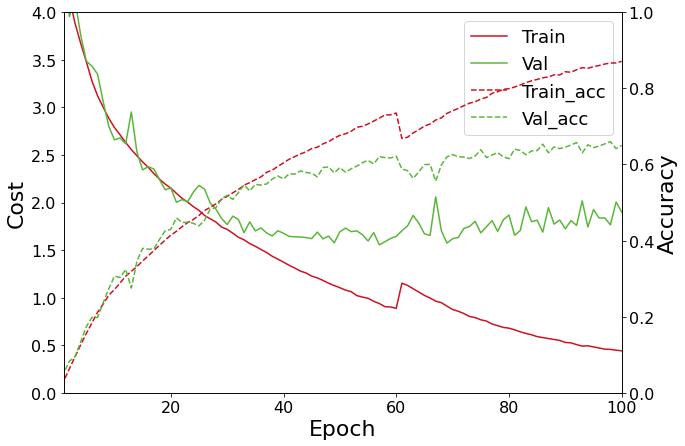

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
result = result_list.T
epoch = result[0]
train_loss = result[1]
val_loss = result[2]
train_acc = result[3]
val_acc = result[4]

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlim(1, 100)
ax1.set_ylim(0, 4)
ax1.tick_params(labelsize=16)
ax1.set_xlabel("Epoch", fontsize=22)
ax1.set_ylabel("Cost", fontsize=22)
ax1.plot(epoch, train_loss, color="#ce1021", label="Train")
ax1.plot(epoch, val_loss, color="#5ab639", label="Val")

ax2 = ax1.twinx()
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("Accuracy", fontsize=22)
ax2.plot(epoch, train_acc, color="#ce1021",linestyle = "dashed", label="Train_acc")
ax2.plot(epoch, val_acc, color="#5ab639",linestyle = "dashed", label="Val_acc")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, fontsize=18, loc='upper right')

plt.show()

#**Image classification on validation data**

Pred:  cloud
Correct:  bee


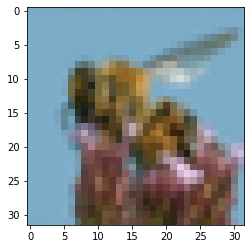

In [ ]:
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cifar_val = torchvision.datasets.CIFAR100(root="CIFAR100", download=False, train=False, transform=None)
images, labels=[], []
for sample in cifar_val:
  image, label = sample
  images.append(image)
  labels.append(label)

idx = 51
img_src = images[idx]
plt.imshow(img_src)
label = labels[idx]

trans = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor()])
img = trans(img_src)
img_batch = img[None]

model.eval()
torch.backends.cudnn.benchmark = True

with torch.cuda.amp.autocast():
  prediction = model(img_batch.to(device))
idx = torch.argmax(prediction[0])
print("Pred: ", cifar_classes[idx])
print("Correct: ", cifar_classes[label])